In [12]:
import requests, io, sys, time, math, json, re
import pandas as pd
import numpy as np
from datetime import date
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


In [13]:
import requests, pandas as pd
from bs4 import BeautifulSoup

TARGET = {"Kazakhstan","Kyrgyzstan","Uzbekistan","Tajikistan","Turkmenistan"}

def scrape_central_asia_countries():
    url = "https://en.wikipedia.org/wiki/Central_Asia"
    headers = {"User-Agent": "SIS-edu-scraper/1.0"}
    html = requests.get(url, timeout=30, headers=headers).text
    soup = BeautifulSoup(html, "html.parser")

    found = set()

    for nav in soup.select("table.navbox"):
        header_txt = " ".join(nav.stripped_strings)[:400].lower()
        if "central asia" not in header_txt:
            continue

        for a in nav.select("a[href^='/wiki/']"):
            txt = a.get_text(strip=True)
            if txt in TARGET:
                found.add(txt)

    if len(found) < 5:
        for a in soup.select("a[href^='/wiki/']"):
            txt = a.get_text(strip=True)
            if txt in TARGET:
                found.add(txt)

    if not found:
        found = TARGET.copy()

    df = pd.DataFrame({"country_name": sorted(found)})
    df["source"] = "wikipedia-navbox" if len(found) == 5 else "fallback/mixed"
    return df

df_countries = scrape_central_asia_countries()
df_countries


,country_name,source
0,Kazakhstan,wikipedia-navbox
1,Kyrgyzstan,wikipedia-navbox
2,Tajikistan,wikipedia-navbox
3,Turkmenistan,wikipedia-navbox
4,Uzbekistan,wikipedia-navbox


In [14]:
df_countries.head(5)

,country_name,source
0,Kazakhstan,wikipedia-navbox
1,Kyrgyzstan,wikipedia-navbox
2,Tajikistan,wikipedia-navbox
3,Turkmenistan,wikipedia-navbox
4,Uzbekistan,wikipedia-navbox


In [15]:
ISO2_MAP = {
    "Kazakhstan": "KZ",
    "Kyrgyzstan": "KG",
    "Uzbekistan": "UZ",
    "Tajikistan": "TJ",
    "Turkmenistan": "TM",
}

df_countries["iso2"] = df_countries["country_name"].map(ISO2_MAP)
assert df_countries["iso2"].notna().all(), "Missing ISO2 mapping"
df_countries


,country_name,source,iso2
0,Kazakhstan,wikipedia-navbox,KZ
1,Kyrgyzstan,wikipedia-navbox,KG
2,Tajikistan,wikipedia-navbox,TJ
3,Turkmenistan,wikipedia-navbox,TM
4,Uzbekistan,wikipedia-navbox,UZ


In [16]:
WB_BASE = "https://api.worldbank.org/v2/country/{country}/indicator/{indicator}"

def wb_fetch_indicator(iso2_list, indicator, per_page=20000):
    frames = []
    for iso2 in iso2_list:
        params = {"format": "json", "per_page": per_page}
        url = WB_BASE.format(country=iso2, indicator=indicator)
        r = requests.get(url, params=params, timeout=60)
        r.raise_for_status()
        js = r.json()
        if not isinstance(js, list) or len(js) < 2 or js[1] is None:
            continue
        rows = js[1]
        df = pd.DataFrame(rows)
        df["countryiso2code"] = iso2
        frames.append(df)
        time.sleep(0.2)
    out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    keep = ["countryiso2code", "country", "date", "value", "unit"]
    for c in keep:
        if c not in out.columns: out[c] = np.nan
    out = out[keep].copy()
    out["year"] = pd.to_numeric(out["date"], errors="coerce")
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    return out

iso2_list = df_countries["iso2"].tolist()
df_internet = wb_fetch_indicator(iso2_list, "IT.NET.USER.ZS")   # Internet users, % population
df_tertiary = wb_fetch_indicator(iso2_list, "SE.TER.ENRR")      # Tertiary enrollment, gross %
df_internet.head(), df_tertiary.head()


(  countryiso2code                              country  date    value unit  \
 0              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2024  93.3917        
 1              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2023  92.8785        
 2              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2022  92.2969        
 3              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2021  90.9240        
 4              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2020  85.9426        
 
    year  
 0  2024  
 1  2023  
 2  2022  
 3  2021  
 4  2020  ,
   countryiso2code                              country  date      value unit  \
 0              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2024  53.456420        
 1              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2023  54.656398        
 2              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2022  57.245926        
 3              KZ  {'id': 'KZ', 'value': 'Kazakhstan'}  2021  59.384942        
 4              KZ  {'id': 'KZ', 'value': 'Kazakhsta

In [17]:
name_map = df_countries.set_index("iso2")["country_name"].to_dict()
for d in (df_internet, df_tertiary):
    d["country"] = d["countryiso2code"].map(name_map)

YEAR_MIN = 2000
df_internet = df_internet[df_internet["year"].between(YEAR_MIN, date.today().year)]
df_tertiary = df_tertiary[df_tertiary["year"].between(YEAR_MIN, date.today().year)]

df_internet = df_internet.rename(columns={"value":"internet_users_pct"})
df_tertiary = df_tertiary.rename(columns={"value":"tertiary_enrollment_pct"})

merged = pd.merge(
    df_internet[["country","year","internet_users_pct"]],
    df_tertiary[["country","year","tertiary_enrollment_pct"]],
    on=["country","year"], how="outer"
)

merged = merged.sort_values(["country","year"])
merged.head(10)


,country,year,internet_users_pct,tertiary_enrollment_pct
0,Kazakhstan,2000,0.668594,30.799259
1,Kazakhstan,2001,1.006120,NaN
2,Kazakhstan,2002,1.674770,NaN
3,Kazakhstan,2003,2.000410,NaN
4,Kazakhstan,2004,2.650390,NaN
5,Kazakhstan,2005,2.961710,NaN
6,Kazakhstan,2006,3.268370,54.524059
7,Kazakhstan,2007,4.020000,NaN
8,Kazakhstan,2008,11.000000,NaN
9,Kazakhstan,2009,18.200000,NaN


In [18]:
desc = merged[["internet_users_pct","tertiary_enrollment_pct"]].describe()
print(desc)

corr_by_country = (
    merged.dropna(subset=["internet_users_pct","tertiary_enrollment_pct"])
          .groupby("country")[["internet_users_pct","tertiary_enrollment_pct"]]
          .corr().iloc[0::2, -1].rename("corr_internet_tertiary")
)
corr_by_country


       internet_users_pct  tertiary_enrollment_pct
count           113.00000                97.000000
mean             27.60153                31.250732
std              29.92464                16.579262
min               0.04860                 7.000936
25%               2.99927                15.972096
50%              15.70000                31.701936
75%              50.60000                45.759177
max              93.39170                62.292137


,,corr_internet_tertiary
country,,
Kazakhstan,internet_users_pct,0.635009
Kyrgyzstan,internet_users_pct,0.662095
Tajikistan,internet_users_pct,0.944175
Turkmenistan,internet_users_pct,NaN
Uzbekistan,internet_users_pct,0.600116


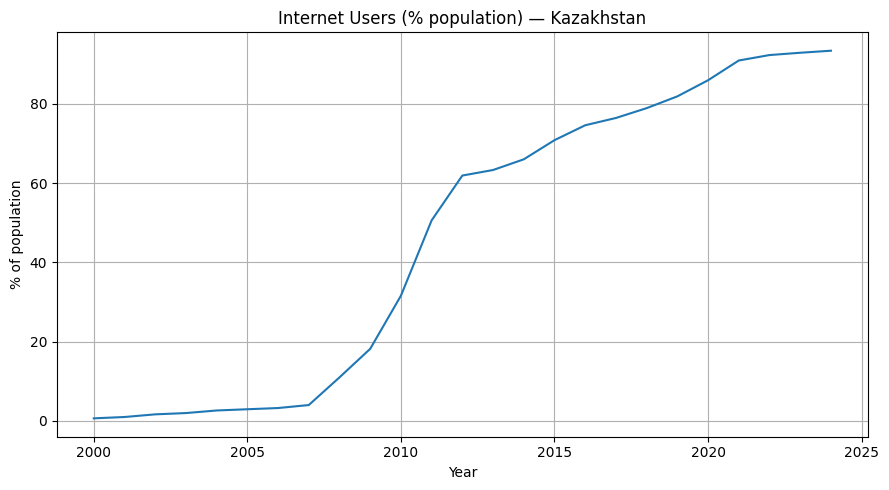

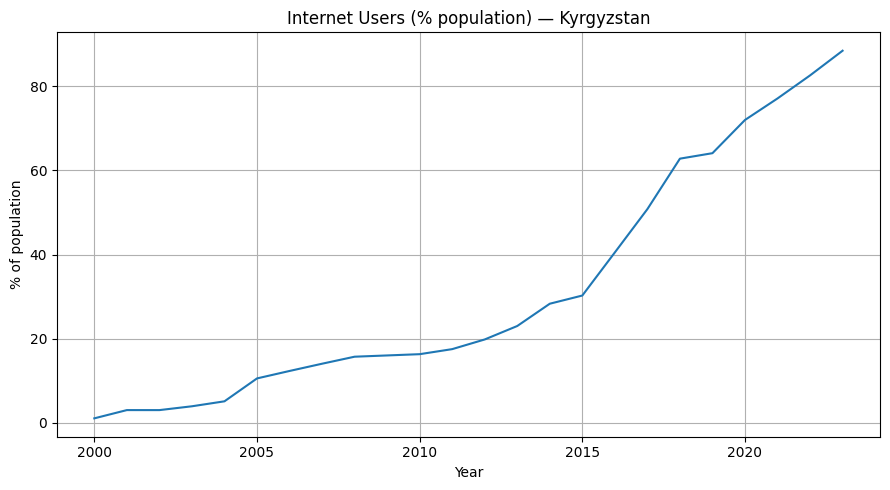

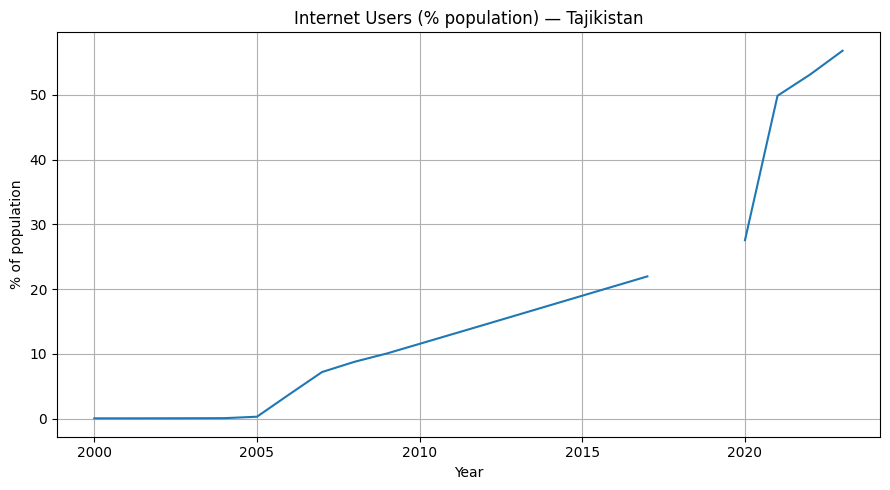

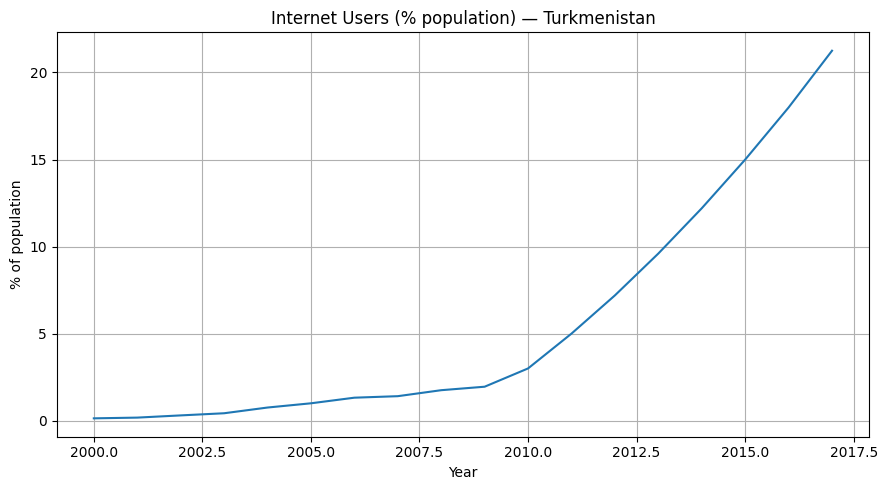

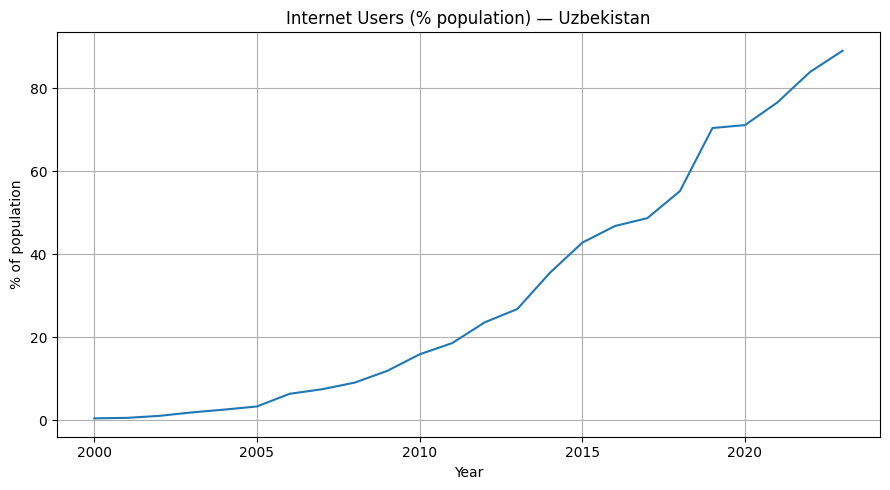

In [19]:
for c in df_countries["country_name"]:
    subset = merged[merged["country"]==c].sort_values("year")
    plt.figure()
    plt.plot(subset["year"], subset["internet_users_pct"])
    plt.title(f"Internet Users (% population) — {c}")
    plt.xlabel("Year"); plt.ylabel("% of population")
    plt.tight_layout()
    plt.show()


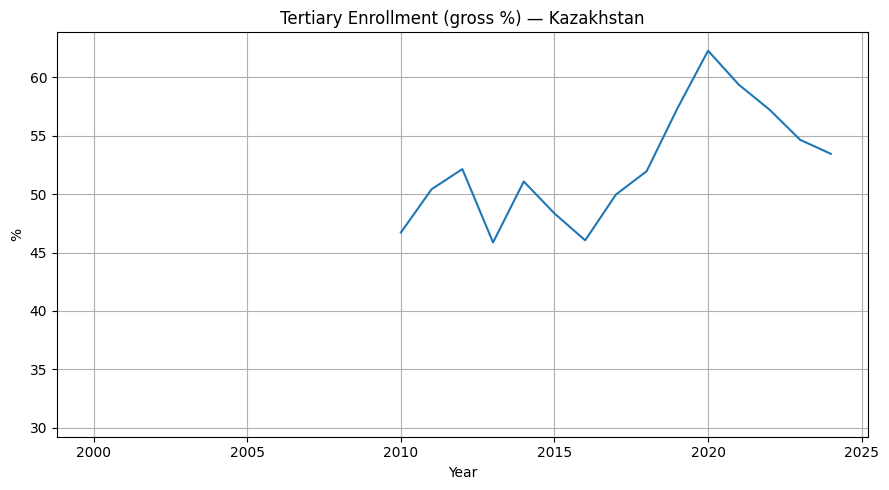

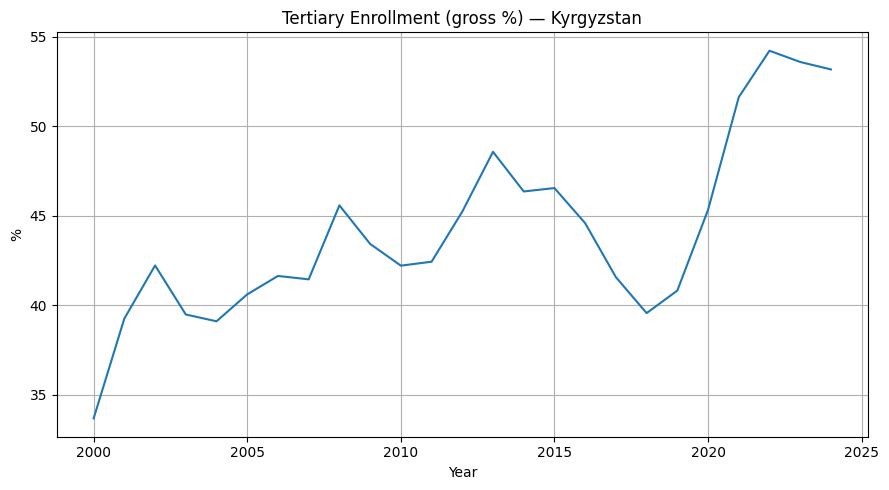

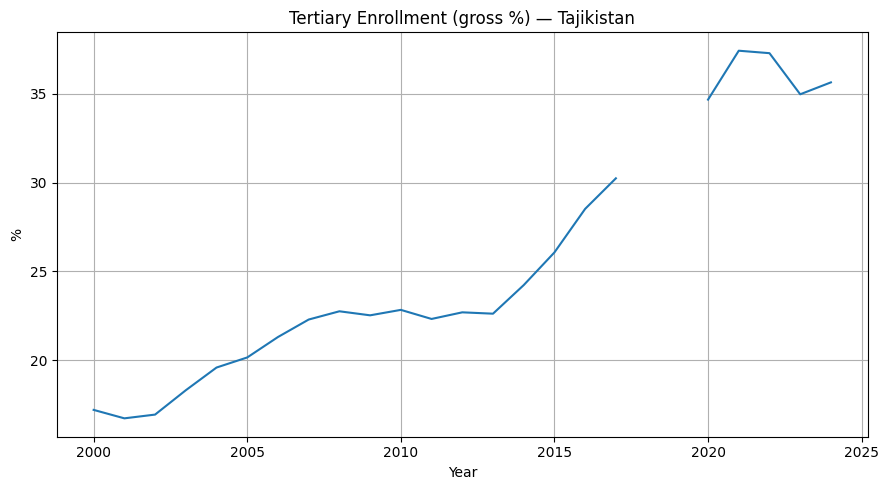

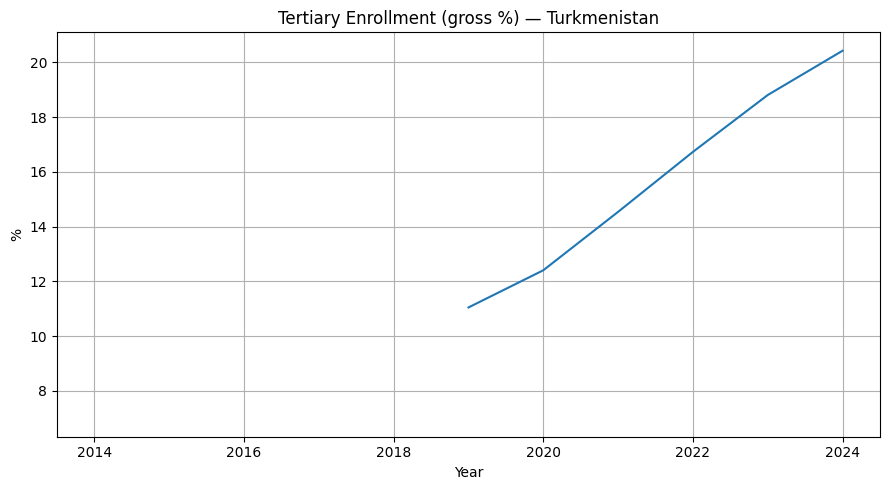

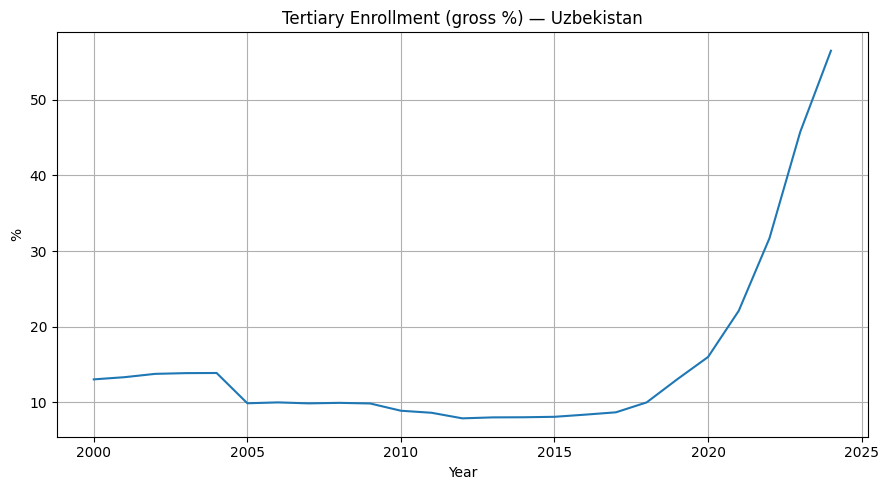

In [20]:
for c in df_countries["country_name"]:
    subset = merged[merged["country"]==c].sort_values("year")
    plt.figure()
    plt.plot(subset["year"], subset["tertiary_enrollment_pct"])
    plt.title(f"Tertiary Enrollment (gross %) — {c}")
    plt.xlabel("Year"); plt.ylabel("%")
    plt.tight_layout()
    plt.show()


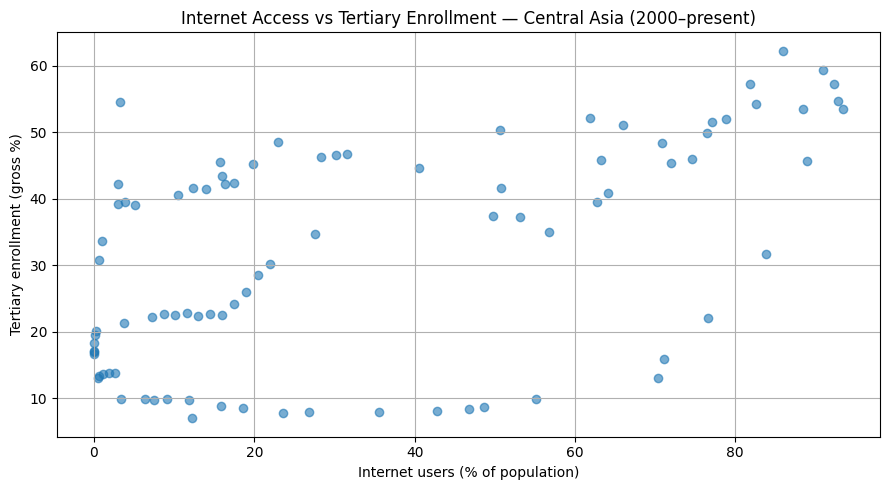

In [21]:
df_scatter = merged.dropna(subset=["internet_users_pct","tertiary_enrollment_pct"]).copy()
plt.figure()
plt.scatter(df_scatter["internet_users_pct"], df_scatter["tertiary_enrollment_pct"], alpha=0.6)
plt.title("Internet Access vs Tertiary Enrollment — Central Asia (2000–present)")
plt.xlabel("Internet users (% of population)")
plt.ylabel("Tertiary enrollment (gross %)")
plt.tight_layout()
plt.show()


In [22]:
ISO2_MAP = {
    "Kazakhstan": "KZ",
    "Kyrgyzstan": "KG",
    "Uzbekistan": "UZ",
    "Tajikistan": "TJ",
    "Turkmenistan": "TM",
}
df_countries["iso2"] = df_countries["country_name"].map(ISO2_MAP)
assert df_countries["iso2"].notna().all(), "Missing ISO2 mapping"

iso2_list = df_countries["iso2"].tolist()
